In [1]:
# Group number 1
# Assignment 9: Extended Kalman filter for navigation and tracking
# Team members: Stepan Perminov, Polina Ponomareva, Kirill Shcherbakov, Daniil Svirskiy

# Library importing
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

In [2]:
class Trajectory(object):
    def __init__(self, N, T, Xc0, Vc0, sD2, sb2, sa2, a):
        
        # Trajectories
        self.Xc = self.true_c_trajectory(N, T, Xc0, Vc0, sa2, a)
        self.Xp = self.true_p_trajectory(N, self.Xc)
        self.Zp = self.measurements(N, self.Xp, sD2, sb2)
   
    def true_c_trajectory(self, n, T, Xc0, Vc0, sa2, a):
        Xc = np.zeros((2,n))
        Vc = np.zeros((2,n))

        Xc[:, 0] = Xc0
        Vc[:, 0] = Vc0
       
        for i in range(1,n):
            Vc[:, i] = Vc[:, i-1] + a[:, i-1]*T
            Xc[:, i] = Xc[:, i-1] + Vc[:, i-1]*T + (a[:, i-1]*T*T)/2
        return Xc
    
    def true_p_trajectory(self, n, Xc):
        Xp = np.zeros((2,n))
        Xp[0,:] = np.sqrt(Xc[0,:]**2 + Xc[1,:]**2) #D
        Xp[1,:] = np.arctan(Xc[0,:]/Xc[1,:]) #bet
        return Xp

    def measurements(self, n, Xp, sD2, sb2):
        Zp = np.zeros((2,n))
        Zp[0,:] = Xp[0,:] + np.random.normal(0, np.sqrt(sD2), n) #D
        Zp[1,:] = Xp[1,:] + np.random.normal(0, np.sqrt(sb2), n) #bet
        return Zp

In [3]:
class Filtration(object):
    def __init__(self, Zp, N, T, sD2, sb2, sa2):
        
        # Trajectories
        self.Zc = self.pseudo_measurements(N, Zp)
        
        # Initial conditions for Kalman filter algorithm
        X0 = np.array([Zp[0, 0]*np.sin(Zp[1, 0]), 0, Zp[0, 0]*np.cos(Zp[1, 0]), 0])
        P0 = np.eye(4)*(10**10)
        F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
        G = np.array([[T*T/2, 0], [T, 0], [0, T*T/2], [0, T]])
        Q = G.dot(G.T)*sa2
        
        # Covariance matrix of measurement error R
        R = np.array([[sD2, 0], [0, sb2]])
        
        self.Kalman = self.Kalman_filtration(N, P0, X0, F, R, Q, Zp)
         
    def pseudo_measurements(self, n, Zp):
        Zc = np.zeros((2,n))
        Zc[0,:] = Zp[0,:]*np.sin(Zp[1,:]) #x
        Zc[1,:] = Zp[0,:]*np.cos(Zp[1,:]) #y
        return Zc
    
    def Kalman_filtration(self, n, P0, X0, F, R, Q, Zp):
        # Initialization of matrixes
        P_1 = np.zeros((4,4,n))
        X_1 = np.zeros((4,n))
        P_ = np.zeros((4,4,n))
        X_ = np.zeros((4,n))
        dh = np.zeros((2,4,n))
        K = np.zeros((4,2,n))

        # Initial P for filtering
        P_[:,:,0] = P0

        # Initial X_filt for filtering
        X_[:,0] = X0

        # Kalman filtering
        for i in range(1,n):
            P_1[:,:,i] = (F.dot(P_[:,:,i-1])).dot(F.T) + Q

            X_1[:,i] = F.dot(X_[:,i-1].reshape(4,1)).reshape(4)
            
            dh[:,:,i] = np.array([[X_1[0,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0, X_1[2,i]/np.sqrt(X_1[0,i]**2 + X_1[2,i]**2), 0], [X_1[2,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0, -X_1[0,i]/(X_1[0,i]**2 + X_1[2,i]**2), 0]])              
           
            K[:,:,i] = (P_1[:,:,i].dot(dh[:,:,i].T)).dot(inv((dh[:,:,i].dot(P_1[:,:,i])).dot(dh[:,:,i].T) + R)) #4 on 2
            
            D = np.sqrt(X_1[0,i]**2 + X_1[2,i]**2)
            bet = np.arctan(X_1[0,i]/X_1[2,i])
            h = np.array([D, bet])

            X_[:,i] = (X_1[:,i].reshape(4,1) + K[:,:,i].dot(Zp[:,i].reshape(2,1) - h.reshape(2,1))).reshape(4)
            P_[:,:,i] = P_1[:,:,i] - (K[:,:,i].dot(dh[:,:,i])).dot(P_1[:,:,i])

        K = np.delete(K, 0, axis = 2)
       
        X_est = np.zeros((4,n))
        X_est[0,:] = np.sqrt(X_1[0,:]**2 + X_1[2,:]**2)
        X_est[1,:] = np.arctan(X_1[0,:]/X_1[2,:])
        X_est[2,:] = np.sqrt(X_[0,:]**2 + X_[2,:]**2)
        X_est[3,:] = np.arctan(X_[0,:]/X_[2,:])
        
        # print(X_est[1,:])
        
        return X_est

In [4]:
# Parameters
N = 500 #points
T = 1 #interval between measurements
Xc_init = np.ones(2)*1000
Vc_init = np.ones(2)*10
sigma_a2 = 0.3**2
sigma_D2 = 50**2
sigma_b2 = 0.004**2

/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in divide


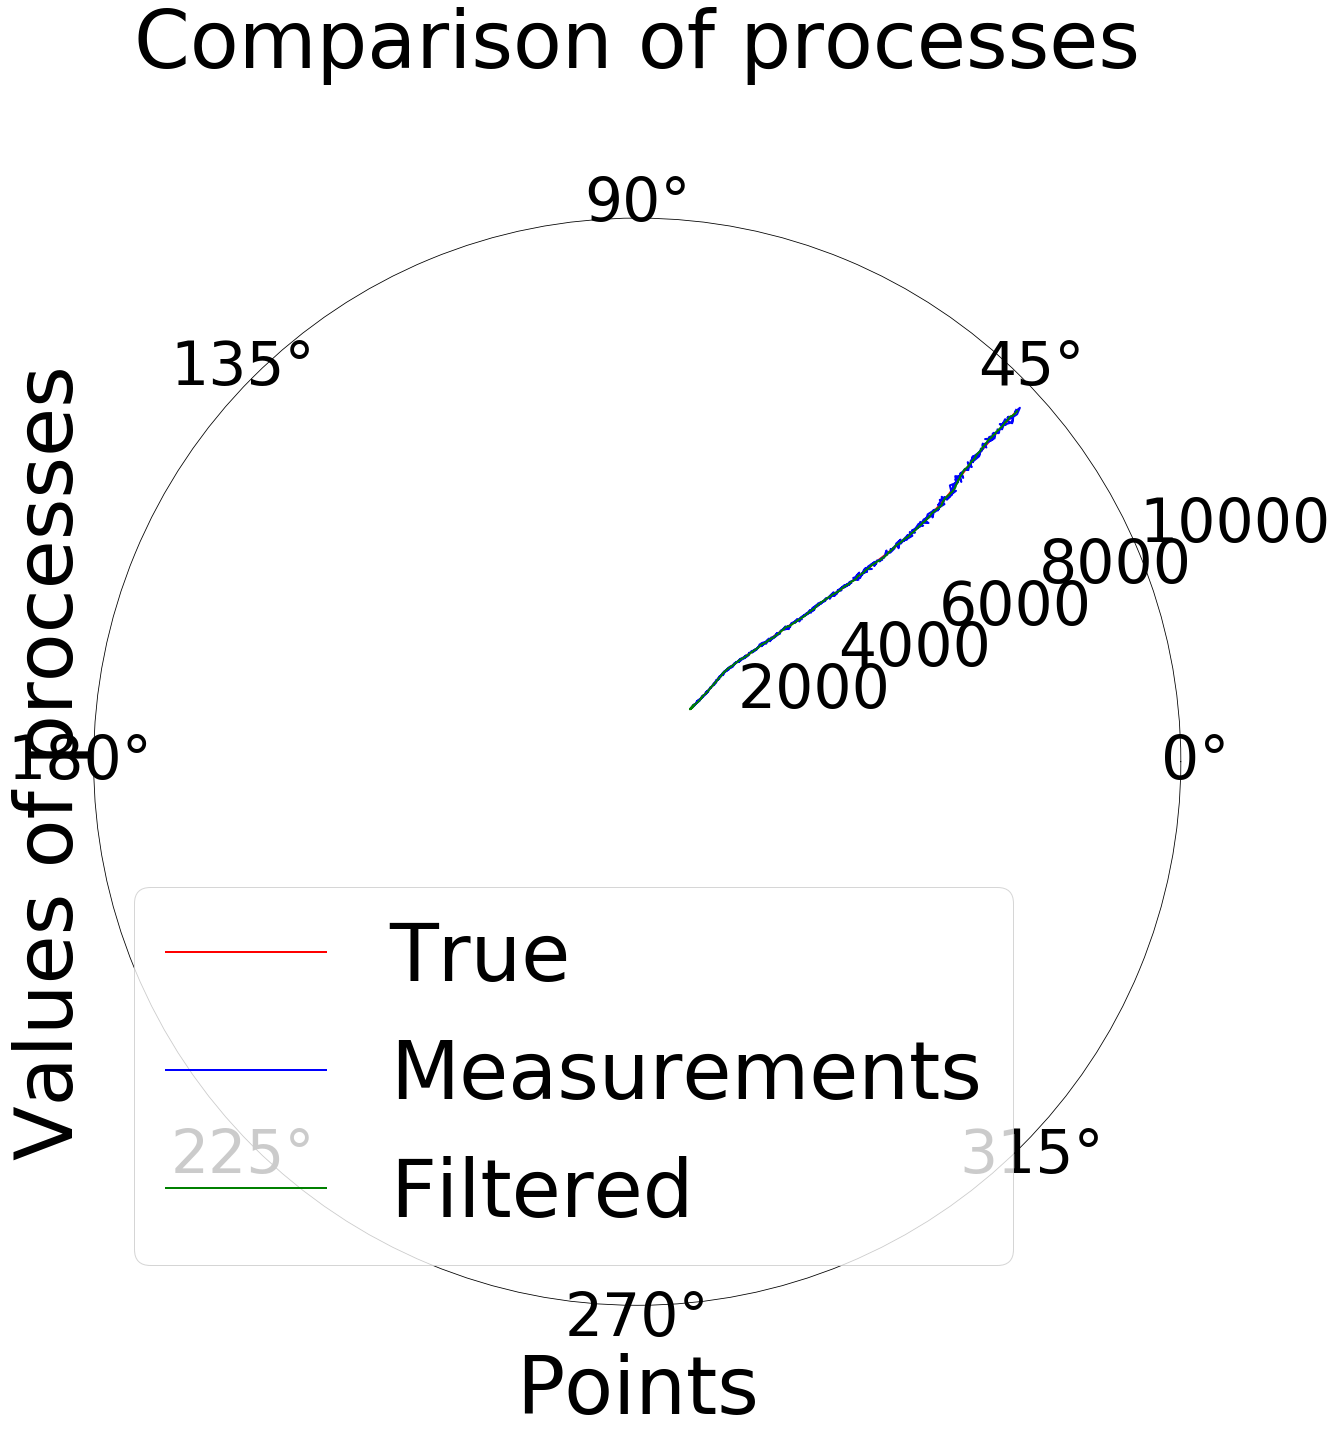

In [6]:
if __name__ == "__main__":
    a = np.zeros((2,N))
    a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
    
    Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a).Xp
    Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a).Zp
    
    Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2).Kalman
    # print(Ans[2,:])
    
    plt.polar(Xp[1,:],Xp[0,:], linewidth = 2, label = "True", color = "r")
    plt.polar(Zp[1,:],Zp[0,:], linewidth = 2, label = "Measurements", color = "b")
    plt.polar(Ans[3,:],Ans[2,:], linewidth = 2, label = "Filtered", color = "g")
    
    
    plt.legend(fontsize = 80)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 80)
    plt.ylabel("Values of processes", fontsize = 80)
    plt.title("Comparison of processes\n", fontsize = 80)
    plt.show()


/home/steplerchik/PycharmProjects/Ass10/venv/lib/python2.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in divide


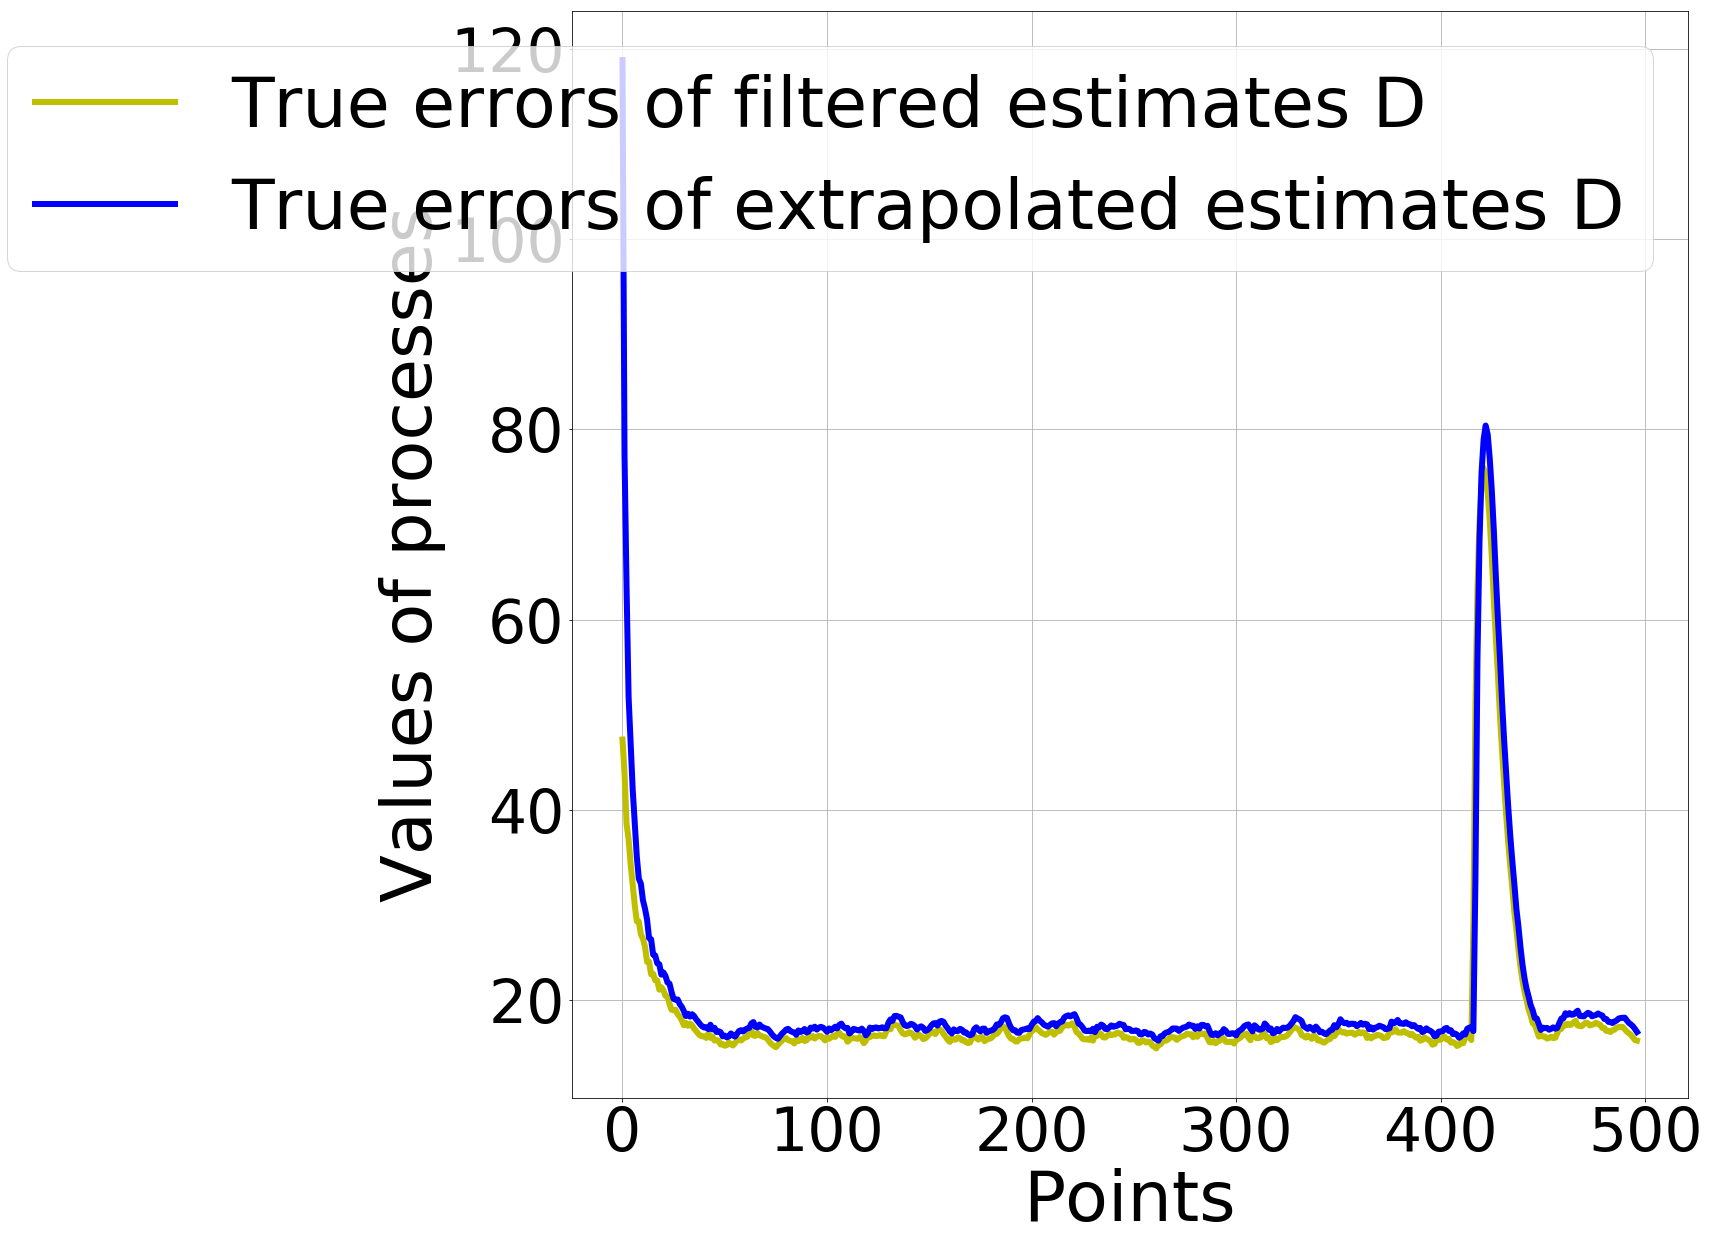

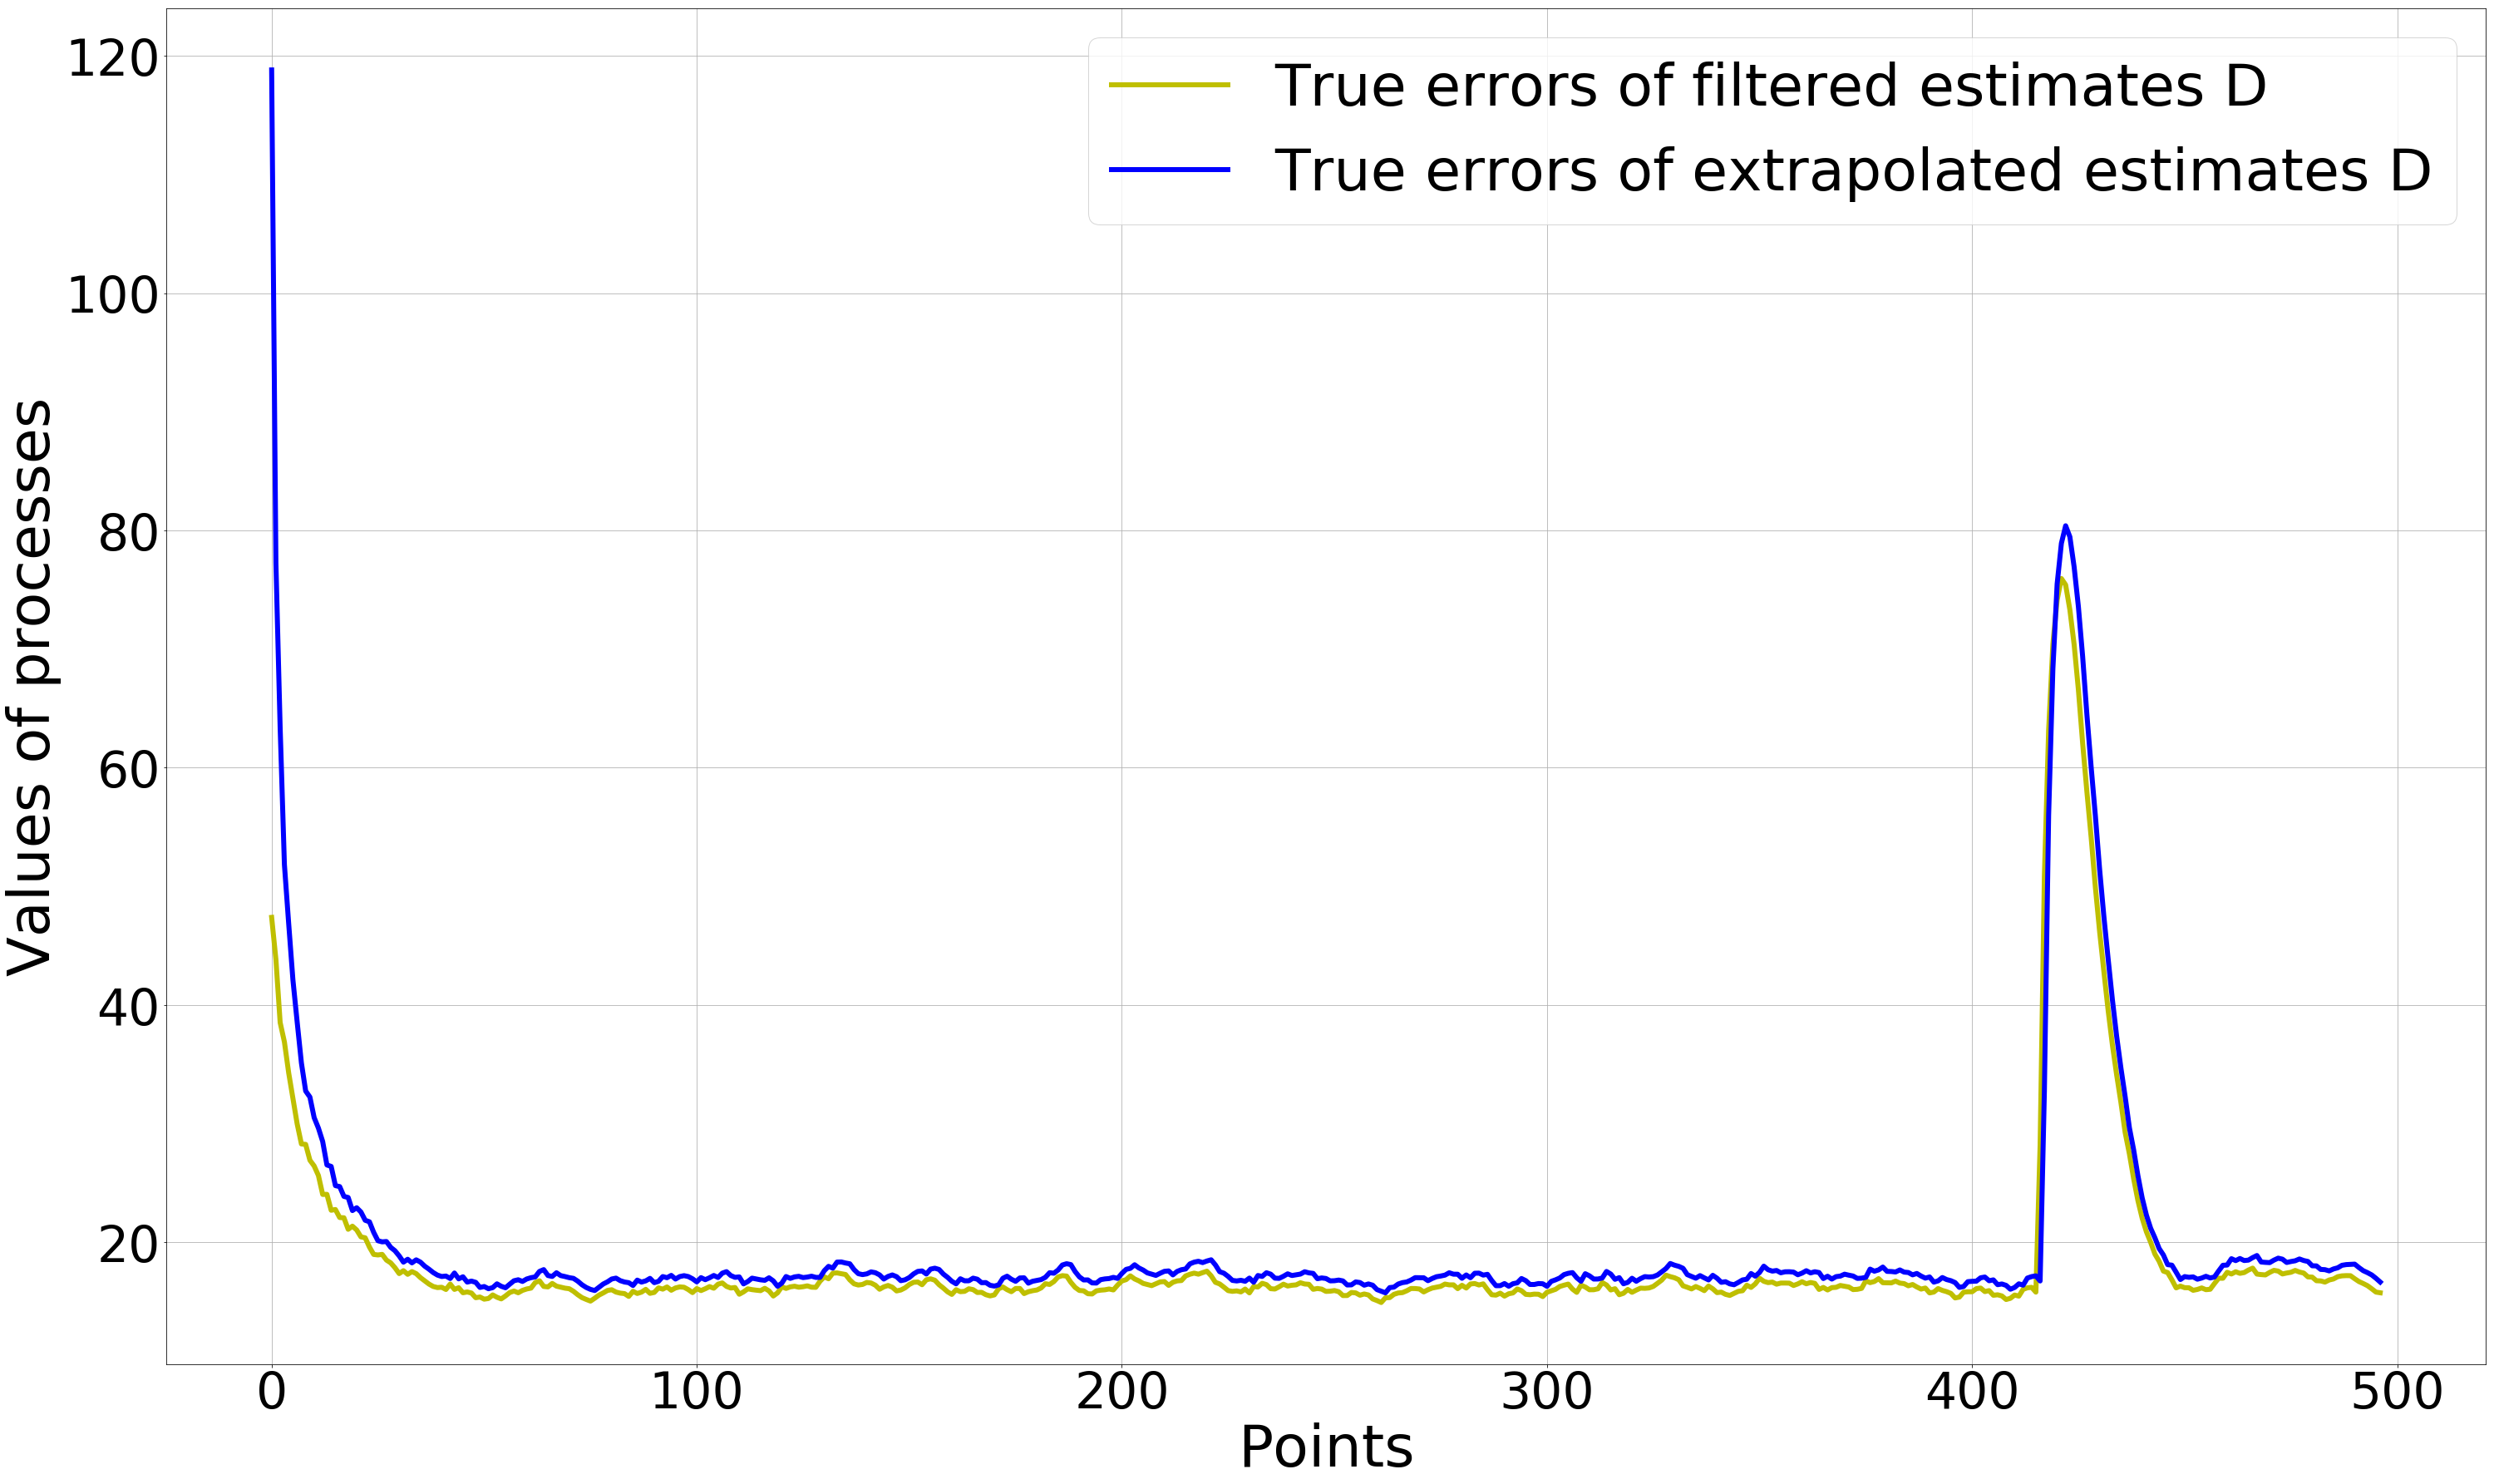

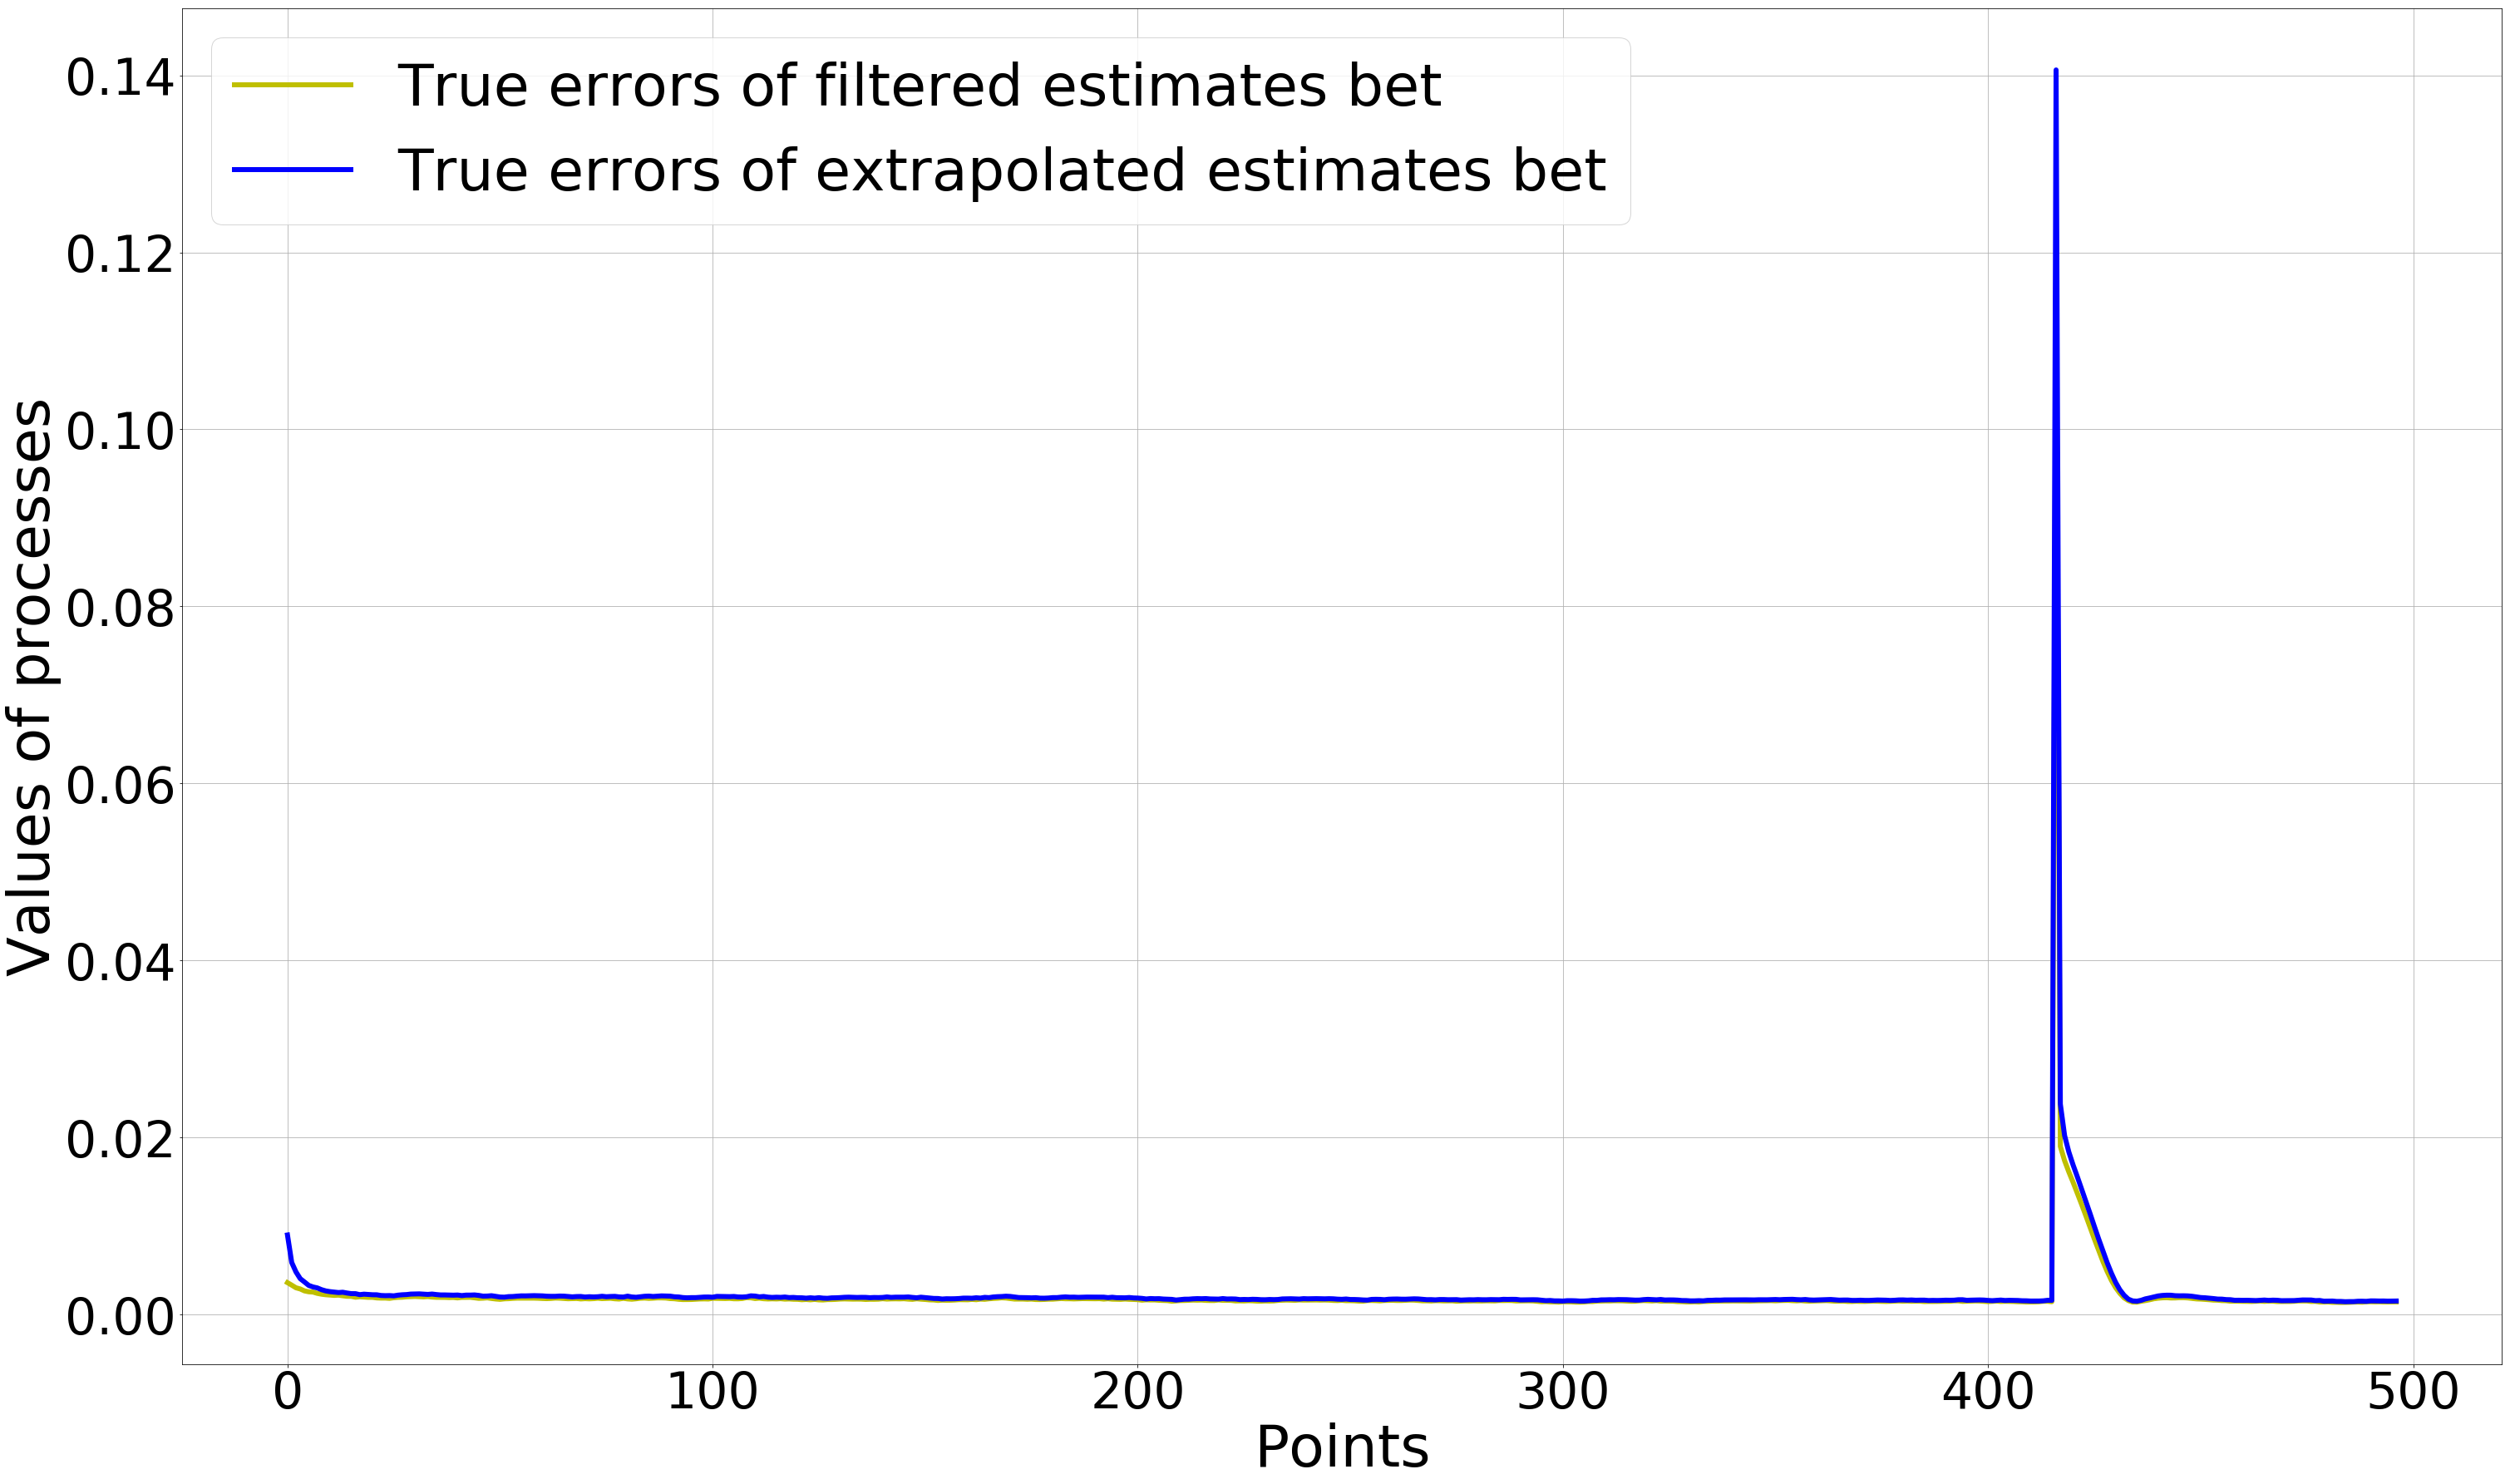

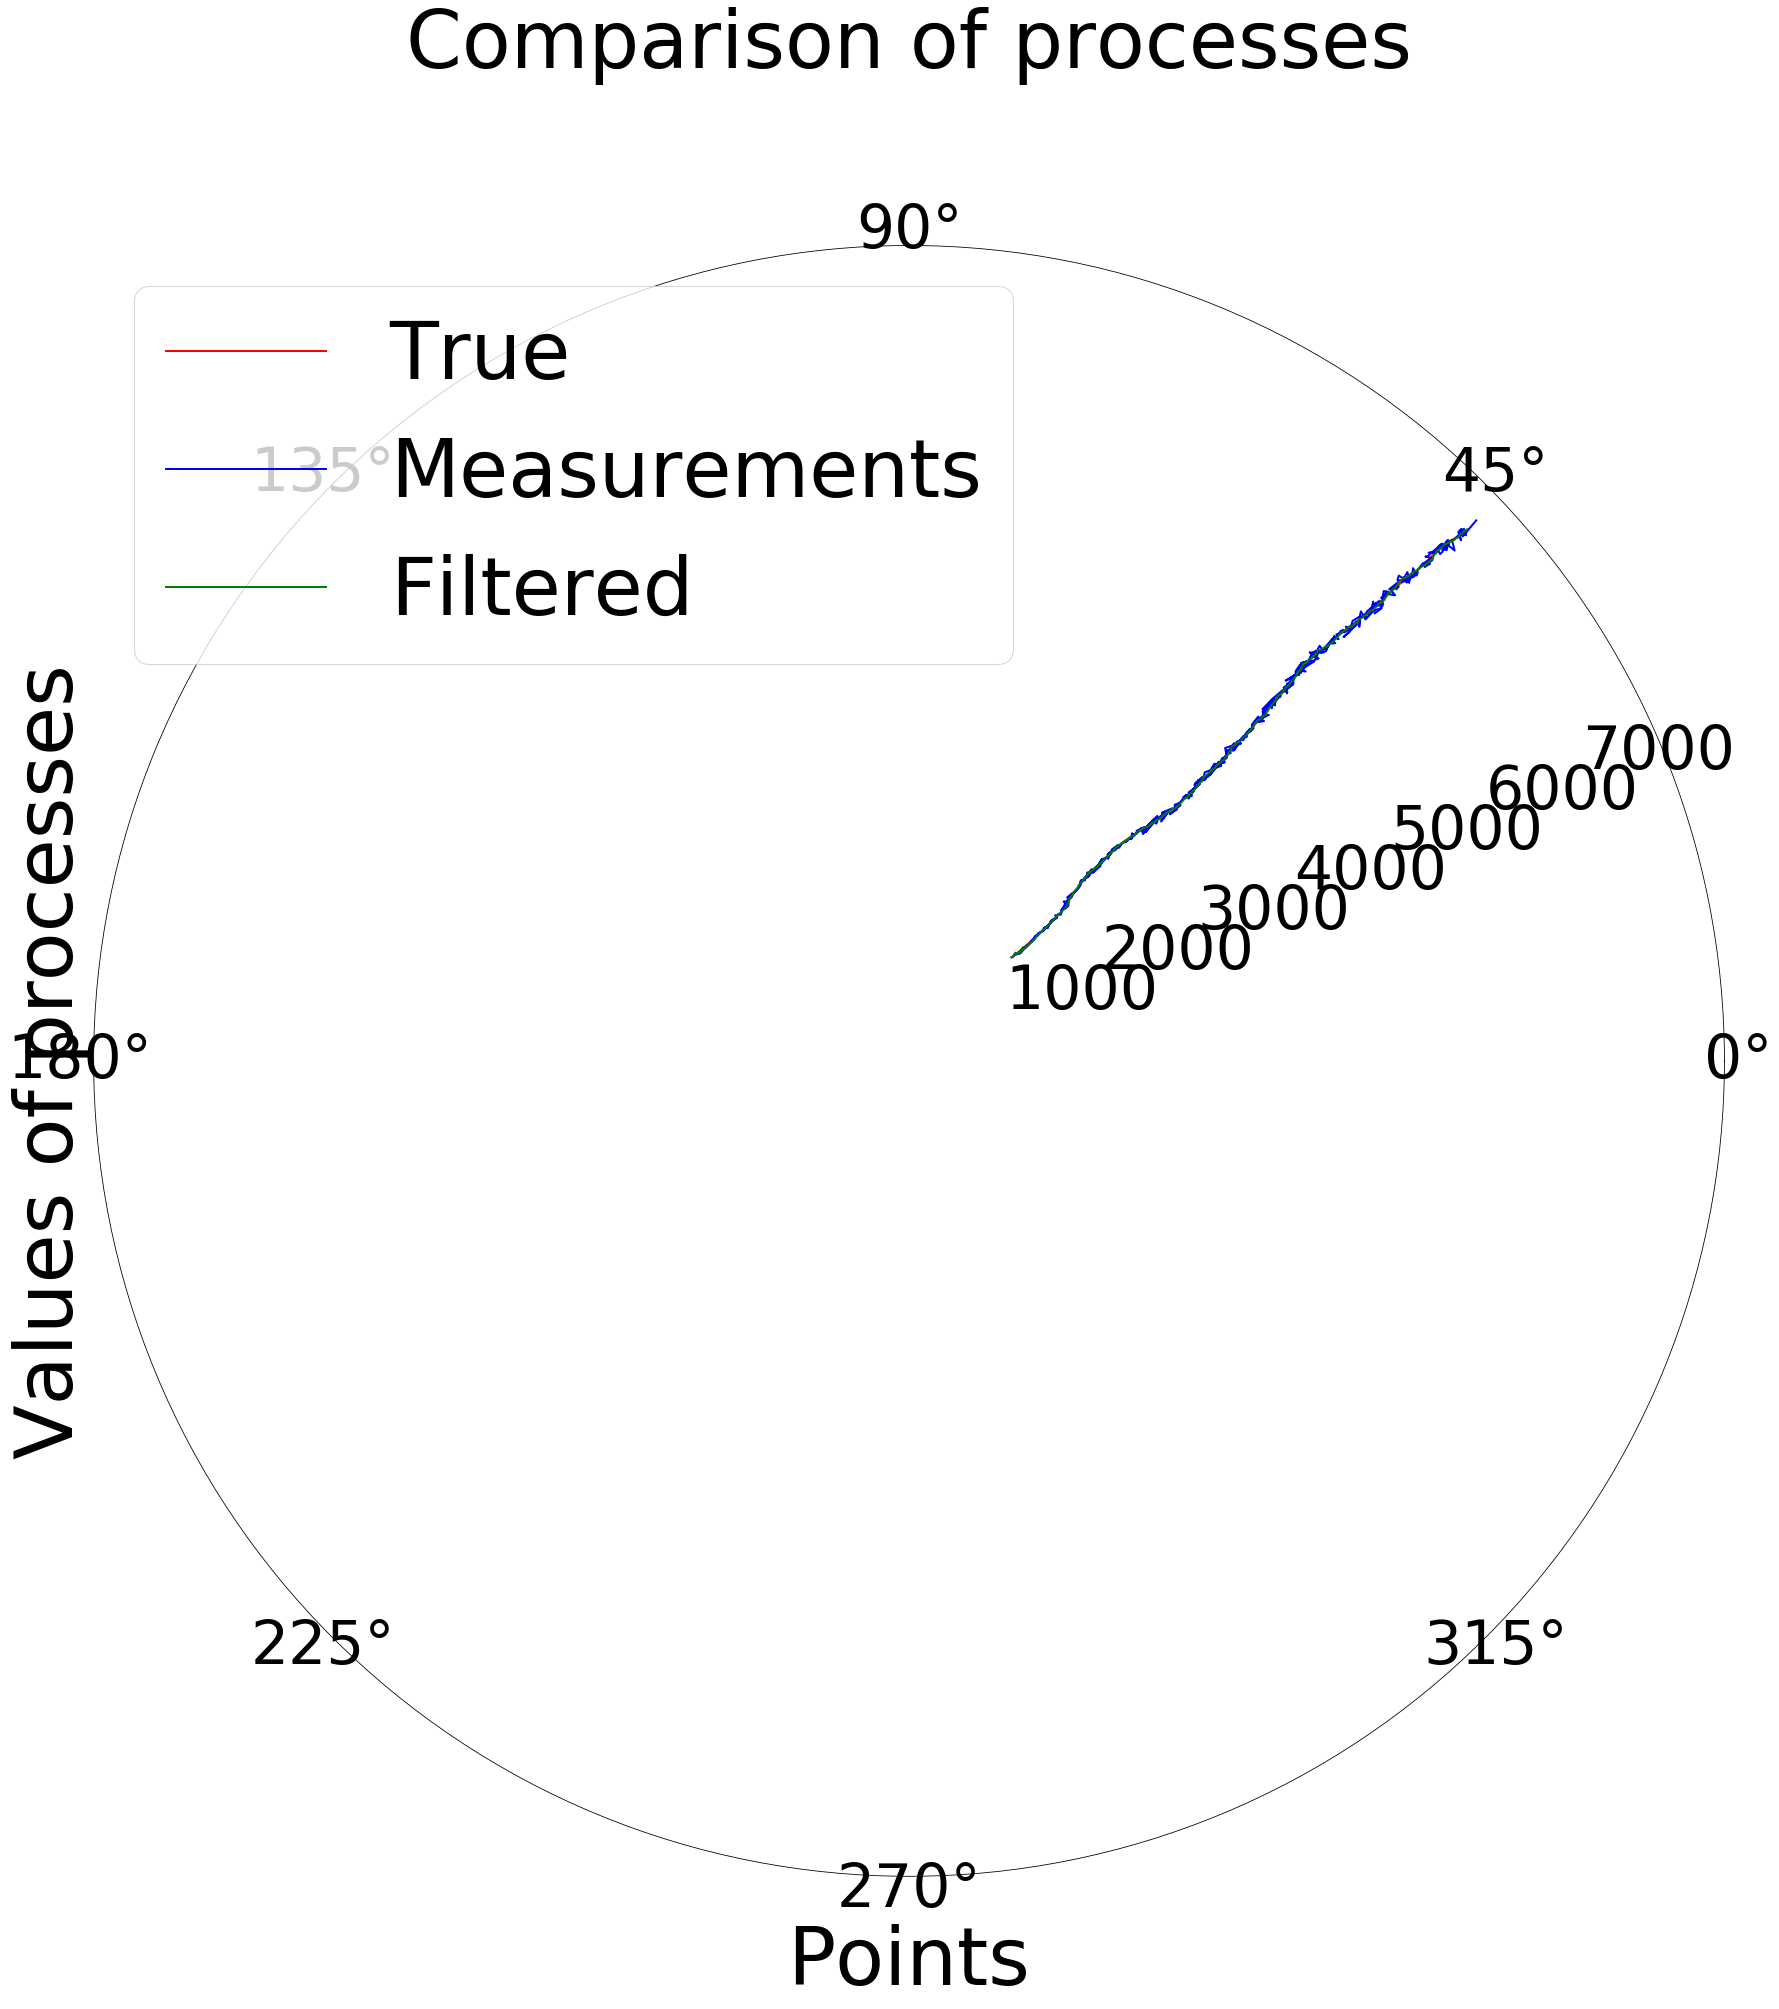

In [11]:
if __name__ == "__main__":
    
    Error_filt = np.zeros((2,N,500))
    Error_extr = np.zeros((2,N,500))
    
    for k in range(500):
        a = np.zeros((2,N))
        a[0,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        a[1,:] = np.random.normal(0, np.sqrt(sigma_a2), N)
        
        Xp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a).Xp
        Zp = Trajectory(N, T, Xc_init, Vc_init, sigma_D2, sigma_b2, sigma_a2, a).Zp
        
        Ans = Filtration(Zp, N, T, sigma_D2, sigma_b2, sigma_a2).Kalman

        est_filt = Ans[2:,:]
        est_extr = Ans[:2,:]
        Error_filt[:,:,k] = (Xp - est_filt)**2
        Error_extr[:,:,k] = (Xp - est_extr)**2

    Final_err_filt = np.sqrt(np.sum(Error_filt, axis = 2)/(500.0-1.0))
    Final_err_extr = np.sqrt(np.sum(Error_extr, axis = 2)/(500.0-1.0))

    # Compare of true errors of extrapolation and filtration of D
    plt.plot(Final_err_filt[0,3:], linewidth = 6, label = "True errors of filtered estimates D", color = "y")
    plt.plot(Final_err_extr[0,3:], linewidth = 6, label = "True errors of extrapolated estimates D", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()
    
    # Compare of true errors of extrapolation and filtration of D
    plt.plot(Final_err_filt[0,3:], linewidth = 6, label = "True errors of filtered estimates D", color = "y")
    plt.plot(Final_err_extr[0,3:], linewidth = 6, label = "True errors of extrapolated estimates D", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()
    
    plt.plot(Final_err_filt[1,3:], linewidth = 6, label = "True errors of filtered estimates bet", color = "y")
    plt.plot(Final_err_extr[1,3:], linewidth = 6, label = "True errors of extrapolated estimates bet", color = "b")
    
    plt.legend(fontsize = 70)
    plt.rcParams["figure.figsize"] = (50,30)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 70)
    plt.ylabel("Values of processes", fontsize = 70)
    # plt.title("Compare of true errors of extrapolation and filtration of D\n", fontsize = 70)
    plt.show()

    plt.polar(Xp[1,:],Xp[0,:], linewidth = 2, label = "True", color = "r")
    plt.polar(Zp[1,:],Zp[0,:], linewidth = 2, label = "Measurements", color = "b")
    plt.polar(Ans[3,:],Ans[2,:], linewidth = 2, label = "Filtered", color = "g")
    
    
    plt.legend(fontsize = 80)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.tick_params(labelsize = 60)
    plt.grid()
    plt.xlabel("Points", fontsize = 80)
    plt.ylabel("Values of processes", fontsize = 80)
    plt.title("Comparison of processes\n", fontsize = 80)
    plt.show()














In [9]:
import numpy as np
a = np.random.uniform(3,4,10)

b = a < 3.5

print(b)

print(np.where(b))

[ True  True False False False False False False  True False]
(array([0, 1, 8]),)


In [17]:
data = '1 2 3'
str = data.data.split()
print(str)

AttributeError: 'str' object has no attribute 'data'